# Hilfscode
Testsätze und -pattern sowie Hilfsfunktion um Treffer in diesen zu rendern

In [1]:
from IPython.display import display_markdown

tests = [("Ich bin ein Moofoo der in Barfoo lebt.", "foo"),
         ("And the magician said: 'abracadabracadabra, simsalabim!'", "abracadabra"),
         ("CPM_annual_conference_announce", "announce"),
         ("I have an overlapping patpattpattern!", "pattern"),
         ("Pattern ganz am Ende?", "nde?"),
         ("Pattern ganz am Anfang?", "Pat")]

def print_highlighted_tests(search_fn):
    # FIXME: This breaks for overlapping patterns!
    out = []
    for text, pattern in tests:
        ranges = []
        for start in search_fn(text, pattern):
            end = start+len(pattern)
            overlap = next((x for x in ranges if x[1] > start), None)
            if overlap:
                start = overlap[0]
                if overlap[1] > end:
                    end = overlap[1]
                ranges.remove(overlap)
            ranges.append((start, end))
        text = list(text)
        for idx, end_idx in ranges:
            text.insert(idx, '**')
            text.insert(end_idx+1, '**')
        display_markdown("`{}`: {}"
                         .format(pattern, "".join(text)), raw=True)

Einfache Automatenimplementierung und Funktion um diese als Graph auszugeben

In [2]:
import pydotplus
from IPython.display import Image

class State:
    """A state in an automaton. """
    
    def __init__(self, id, final=False):
        self.id = id
        self.transitions = {}
        self.final = final
        
    def add_transition(self, label, target):
        self.transitions[label] = target
        
    def follow_path(self, path):
        """ Follow a path through the automaton and return the
             state it leads to.
        """
        if len(path) == 1:
            return self.transitions[path]
        return self.transitions[path[0]].follow_path(path[1:])
    
    def longest_prefix(self, path):
        """ Follow the path through the automaton until there are
            no more transitions. Returns the last reached state
            and the remaining path.
        """
        if not path or path[0] not in self.transitions:
            return self, path
        return self.transitions[path[0]].longest_prefix(path[1:])
    
    def as_dot(self):
        out = []
        if self.final:
            out.append("{} [peripheries=2];\n".format(self.id))
        for transition, next_state in self.transitions.items():
            out.append("{} -> {} [label={}];\n"
                       .format(self.id, next_state.id, transition))
            out.extend([x for x in next_state.as_dot() if x not in out])
        return out
    
    def __str__(self):
        return "<State '{}' with {} transitions{}>".format(
            self.id, str(list(self.transitions.keys())),
            " final" if self.final else "")
    
    __repr__ = __str__

    
def print_automaton(state, debug=False):
    dot_src = "digraph automaton { rankdir=\"LR\"; rank=\"same\"; %s }" % "".join(state.as_dot())
    if debug:
        print(dot_src)
    return Image(pydotplus.graph_from_dot_data(dot_src).create_png(prog='dot'))

# String Matching

## Generelles Prinzip
![](img/window_general.png)

- Ein Suchfenster der Patternlänge wird über den Text geschoben
- Zeichenweise wird das Pattern mit dem Textfenster verglichen
- Bei einem Mismatch wird das Fenster verschoben und der Vergleich
  beginnt von neuem
- Wurde das Fenster ohne Mismatch vollständig durchlaufen liegt ein Treffer
  an der Startposition des Fensters vor
- **Grundproblem**: Wie kann die Verschiebung des Fensters möglichst
   effizient vorgenommen werden, um so wenige Zeichen wie möglich
   vergleichen zu müssen?

## Präfix-basierte Ansätze

![](img/prefix_search.png)


### Naive Stringsuche
- eine Schleife, die über den Text itertiert (kann beendet werden,
  sobald der restliche Text kürzer wäre als das Pattern selbst)
- eine zweite Schleife, die an jeder Position des Textes über die
  nächsten Buchstaben und das Pattern iteriert und abbricht, sobald
  ein Buchstabe im Pattern nicht mit dem aktuellen Buchstaben im Text
  übereinstimmt
- wenn die zweite Schleife komplett durchlaufen wurde, wurde ein Match
  gefunden
- **Problem:** Fenster wird immer nur um eine einzige Textposition
  verschoben, was sehr ineffizient ist.

In [3]:
def simple_search(text, pattern):
    # Walk forwards through the text
    for text_idx in range(len(text) - len(pattern) + 1):
        # Walk forwards through the pattern
        for pat_idx, char in enumerate(pattern):
            # Does the text match the pattern?
            if char != text[text_idx+pat_idx]:
                # Nay, go to the next character in the text
                # and try the pattern again
                break
        else:
            # Yay, we got a match! (Because all pattern symbols matched)
            yield text_idx

print_highlighted_tests(simple_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

### Knuth-Morris-Pratt

![](img/kmp_search.png)

- das selbe Prinzip wie beim Simple Pattern Matching
- das Pattern wird jedoch bei einem Mismatch von Buchstaben “weiter
  nach vorne geschoben”
- hierbei hilft eine Prefix-Tabelle (auch Next-Funktion) die die
  “Verschiebepositionen” speichert. (Die Verschiebeposition ist die Länge des
  längsten Suffix des Teils des Patterns der gefunden wurde, der gleichzeitig
  Präfix des gesamten Patterns ist)

<!-- TODO: besserer Code hier?! -->

In [4]:
def get_prefix_table(pattern):
    i, j = 0, -1
    prefix_table = [-1] * (len(pattern) + 1)
    while i < len(pattern):
        while j >= 0 and pattern[j] != pattern[i]:
            j = prefix_table[j]
        i += 1
        j += 1
        if i == len(pattern):
            prefix_table[i] = j
        elif pattern[i] != pattern[j]:
            prefix_table[i] = j
        else:
            prefix_table[i] = prefix_table[j]
    return prefix_table

print(get_prefix_table('abracadabra'))

[-1, 0, 0, -1, 1, -1, 1, -1, 0, 0, -1, 4]


| 0 | 1 | 2 |  3 | 4 |  5 | 6 |  7 | 8 | 9 | 10 | match |
|---|---|---|----|---|----|---|----|---|---|----|-------|
| a | b | r |  a | c |  a | d |  a | b | r |  a |       |
|-1 | 0 | 0 | -1 | 1 | -1 | 1 | -1 | 0 | 0 | -1 |    4  |

Table: Präfix-Tabelle für das Pattern *abracadabra*

In [5]:
def kmp_search(text, pattern):
    prefix_table = get_prefix_table(pattern)
    text_idx, pat_idx = 0, 0
    # Go through text from left to right
    while text_idx < len(text):
        while pat_idx >= 0 and text[text_idx] != pattern[pat_idx]:
            # If we have a mismatch, go to the pattern position
            # indicated by the table
            pat_idx = prefix_table[pat_idx]
        text_idx += 1
        pat_idx += 1
        if pat_idx == len(pattern):
            yield text_idx - len(pattern)
            pat_idx = prefix_table[pat_idx]

print_highlighted_tests(kmp_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

### Shift-And

![](img/shiftand.png)

- Kann als Automat verstanden werden, der mit Bitvektoren repräsentiert wird
- Für jeden Buchstaben im Pattern wird eine Bitmasken erstellt (alle anderen
  Buchstaben haben den 0-Vektor (mit der Länge des Patterns) als Bitmaske)
- Vektor der einen Automaten repräsentiert, dessen Anfangszustand
  immer aktiv ist, wird durch Shift-Operationen “durchlaufen” und mit
  der Bitmaske des aktuell gelesenen Buchstabens im Text “verundet”
- wenn der letzte Zustand des Automaten aktiv ist, wurde das Pattern
  gefunden
- Endianness der Vektoren ist zu beachten! (immer Big Endian?)

In [6]:
from bitstring import BitArray
from collections import defaultdict

def get_bit_table(pattern):
    alphabet = set(pattern)
    # Every entry represents the *reversed* pattern, with a 1
    # at the positions with the character
    # FIXME: Inefficient, iterates multiple times over pattern,
    #        refactor to do this in one pass
    table = {char: BitArray('0b' + ''.join('1' if c == char else '0'
                                           for c in reversed(pattern)))
             for char in alphabet}
    return table

# bit table for pattern 'abracadabra'
# 0 vectors for other chars are not stored, one such vector is enough
# function shift_and_search generates this one
for k, v in get_bit_table('abracadabra').items():
    print('|', k, '|', v, '|')

| a | 0b10010101001 |
| r | 0b01000000100 |
| d | 0b00001000000 |
| b | 0b00100000010 |
| c | 0b00000010000 |


| letter||   |   |   |   |   |   |   |   |   |   |
|----|---|---|---|---|---|---|---|---|---|---|---|
| a  | 1 | 0 | 0 | 1 | 0 | 1 | 0 | 1 | 0 | 0 | 1 |
| b  | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 |
| r  | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 |
| c  | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 |
| d  | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| \* | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

Table: Bitmasken-Tabelle für das Pattern *abracadabra*

In [7]:
def shift_and_search(text, pattern):
    m = len(pattern)
    bit_table = get_bit_table(pattern)
    # empty vector for all chars not in the pattern
    empty_vec = BitArray(length=m)
    # Vector that represents a full match on the pattern
    found_vec = BitArray('0b1' + '0'*(m-1))  # '1000...'
    # Vector that adds a 'empty_word' transition on the first state
    # to itself
    init_vec = BitArray('0b' + '0'*(m-1) + '1')  # '...0001'
    
    # In the beginning, all states in the NFA are inactive
    automaton = BitArray(length=m)  # '0000...'
    for text_idx, char in enumerate(text):
        # get the bit vector of the current char or the 0-vetor
        char_vec = bit_table.get(char, empty_vec)
        automaton <<= 1        # shift/advance in the NFA
        automaton |= init_vec  # activate the first state
        automaton &= char_vec  # and/activate the character states
        if automaton & found_vec != empty_vec:  # Is the final state active?
              yield text_idx - m + 1  # if so, report a match

print_highlighted_tests(shift_and_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

### Shift-Or
- gleiches Konzept wie beim Shift-And Verfahren
- hier repräsentieren 0en aktive und 1en inaktive Zustände, so kann der
  Schritt des “aktiv machens” des ersten Zustands des Automaten gespart
  werden, da beim shift automatisch eine neue 0 (aktiver Zustand) hinzugefügt
  wird
- alle Bitvektoren sind hier natürlich invertiert

In [8]:
def shift_or_search(text, pattern):
    m = len(pattern)
    # empty vector is now a vector with only 1s
    empty_vec = BitArray('0b' + '1'*m)  # '1111...'
    
    # Vector that represents a full match on the pattern
    found_vec = BitArray('0b0' + '1'*(m-1))  # '0111...'
    
    # XORing with an all-one array of same length creates the complement
    # saves us from implementing a different get_bit_table method
    bit_table = {char: vec ^ empty_vec
                 for char, vec in get_bit_table(pattern).items()}
    
    # In the beginning, all states in the NFA are inactive, i.e. 1
    automaton = BitArray('0b' + '1'*m)  # '1111...'
    for text_idx, char in enumerate(text):
        # shift one left and OR with the current char's vetor or the empty vector
        automaton = (automaton << 1 | bit_table.get(char, empty_vec))
        if (automaton | found_vec) != empty_vec:
              yield text_idx - m + 1

print_highlighted_tests(shift_or_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

## Suffix-basierte Ansätze

![](img/suffix_search.png)

- Anstatt das Suchfenster von links nach rechts zu durchlaufen drehen wir
  die Reihenfolge um und gehen von rechts nach links
- Dies scheint statistisch dazu zu führen dass ein Mismatch schneller
  erkannt wird und wir somit weniger Vergleiche durchführen müssen
  (in natürlichen Sprachen)

### Boyer-Moore
#### (implementiert in grep btw.)

![](img/boyermoore1.png)
![](img/boyermoore2.png)
![](img/boyermoore3.png)

- Pattern wird wie zuvor von links nach rechts durch den Text
  geschoben, jedoch wird nun das Pattern von rechts nach links
  durchlaufen (in natürlichen Sprachen wird so üblicherweise früher
  ein Mismatch gefunden und das Pattern kann schneller
  verschoben werden)
- für die Verschiebung werden zwei Heuristiken angewandt
    *   **Bad-Character Heuristik**  
        bei einem Mismatch kann das Pattern soweit verschoben werden,
        dass der aktuell im Text gelesene Buchstabe mit dem letzten
        vorkommen dieses Buchstabens im Pattern aligniert ist, wenn
        dieser Buchstabe gar nicht im Pattern vorkommt, kann das Pattern
        um seine ganze Länge verschoben werden
    *   **Good-Suffix Heuristik**  
        Wenn das bis zum Mismatch gelesene Suffix des Patterns nochmals
        Infix des Patterns ist, kann das Pattern soweit verschoben
        werden, bis der gelesene Teil mit diesem Infix aligniert ist,
        kommt dieses Suffix kein zweites mal im Pattern vor, kann das
        Pattern um seine ganze Länge verschoben werden
- es wird immer die maximale Verschiebung die sich durch diese
  Heristiken ergeben angewandt


In [9]:
# TODO: finish implementation (good suffix heuristic)

# helper function getting last table for bad character heuristics
# Not the same as Horspool table! (??)
def get_last_table(pattern):
    return {c: pattern.rindex(c) for c in pattern}


def boyer_moore_search(text, pattern):
    m = len(pattern)
    n = len(text)
    text_idx = 0                                 # text index starts left
    last_table = get_last_table(pattern)         # get table for bad char heuristic
    while text_idx <= n-m:                       # go through text up to where the pattern would exceed the texts length
        pat_idx = m                              # pattern index starts right
        #found = ''
        while pat_idx > 0:                       # go through pattern
            pat_idx -= 1                         # right to left
            cur_char = text[text_idx + pat_idx]
            #found += cur_char
            if cur_char != pattern[pat_idx]:     # encountered mismatch
                
                bad_char_shift = last_table.get(cur_char,m-1)  # shift such that the last occurrence of cur_char is aligned
                good_suff_shift = 0                            # TODO: implement this fucker
                
                text_idx += max(bad_char_shift, good_suff_shift)  # shift the most optimistic way
                break                                             # and do not continue this comparison
                
        if pat_idx == 0:                         # pattern was walked completely
            yield text_idx
        #print(found, '\n-----\n')
        text_idx += 1

text = 'some random text here! text'
pattern = 'text'
print(list(boyer_moore_search(text, pattern)))
#expected output: [12, 23]
# print_highlighted_tests(boyer_moore_search)

[12, 23]


### Horspool

![](img/horspool.png)

- Wie bei Boyer-Moore wird der Text von links nach rechts, das Pattern aber
  von rechts nach links durchlaufen
- sobald ein Mismatch erreicht wird, wird das Pattern soweit verschoben, dass
  das gerade gelesene Zeichen im Text mit dem letzen vorkommen dieses Zeichens
  im Pattern alligniert ist
- Das letzte Zeichen des Patterns zählt hier nicht dazu, weil wenn dieses Zeichen
  beim ersten Vergleich schon nicht passt, müssen nur alle anderen Zeichen, die
  im Pattern vorkommen verglichen werden

In [10]:
def get_horspool_table(pattern):
    """ The Horspool table indicates the *last* position *from the right*
        for each character in the pattern, excluding the last character.
    """
    return {char: len(pattern)-j-1
            for j, char in enumerate(pattern[:-1])}

# alternative:
#def get_horspool_table(pattern):
#    rev = pattern[::-1]
#    return {c: rev.index(c) for c in rev[1:]}

print(get_horspool_table('announce'))

{'a': 7, 'o': 4, 'c': 1, 'n': 2, 'u': 3}


In [11]:
def horspool_search(text, pattern):
    n = len(text) - 1
    m = len(pattern) - 1
    table = get_horspool_table(pattern)
    pos = -1
    # Walk through text from left to right
    while pos <= n - m:
        j = m
        # Walk through pattern from right to left
        while j >= 0 and text[pos + j] == pattern[j]:
            j -= 1
        # Did we get through the whole pattern?
        if j == -1:
            yield pos
        current_char = text[pos+m]
        # What's the index of the character in the pattern?
        # If the character is not in the table, use the pattern length
        last_idx_in_pattern = table.get(current_char, m)
        pos += last_idx_in_pattern

print_highlighted_tests(horspool_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

## Faktor-basierte Ansätze

![](img/factor_search.png)
![](img/factor_search2.png)

- Beim Durchlaufen des Patterns wird geschaut, ob der bereits gelesene
  Teil ein Infix des Textes ist.
- So wird verfahren, bis dieses Infix das komplette Pattern ist, oder
  aber ein Mismatch auftritt.
- Bei einem Mismatch kann das Pattern sofort bis nach den "Mismatch-Character" verschoben werden,
  da klar ist, dass das jetzt gelesene Infix (mit diesem Buchstaben) kein Infix des Texts ist

### Backward Nondeterministic DAWG Matching

Ähnlich wie Shift/And, in diesem Fall wird aber nach Faktoren/Infixen des Pattern gesucht um so die Verschiebung zu maximieren.

In [12]:
def bndm_search(text, pattern):
    bit_table = get_bit_table(pattern)
    # Since we're iterating backwards through the pattern,
    # we have to flip the vectors ('0001' -> '1000')
    for vec in bit_table.values():
        vec.reverse()
    empty_vec = BitArray(length=len(pattern))
    found_vec = BitArray('0b1' + '0'*(len(pattern)-1))
    n = len(text) - 1
    m = len(pattern)
    pos = -1
    # Go throught text left-to-right
    while pos <= n - m:
        j = m
        last = m  # Stores TODO: what exactly?
        D = BitArray('0b' + '1'*m)
        # Go through pattern right-to-left
        while D != empty_vec:
            char_vec = bit_table.get(text[pos+j], empty_vec)
            D &= char_vec  # Activate all states the current character
                           # leads to
            j -= 1
            if D & found_vec != empty_vec:
                if j > 0:
                    last = j
                else:
                    yield pos + 1
            D <<= 1
        pos += last
        
print_highlighted_tests(bndm_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

### Backward Oracle Matching

- Es wird ein Automat (das oracle) gebaut, der alle Suffixe des *umgedrehten* Patterns
  erkennt, d.h. auch nur einen String der Länge des Patterns selbst, das Pattern selbst
- Der Text wird von links nach rechts durchgegangen und das Pattern von rechts nach links.
  Gleichzeitig wird mit den gelesenen Buchstaben der Automat durchlaufen.
  Sobald das Pattern komplett durchlaufen ist, wurde ein Match gefunden.
  Wenn ein Buchstabe gelesen wurde mit dem es vom aktiven Zustan des Automaten keinen
  Übergang gibt, wurde ein Mismatch gefunden und das Pattern kann bis nach diesen Buchstaben
  verschoben werden

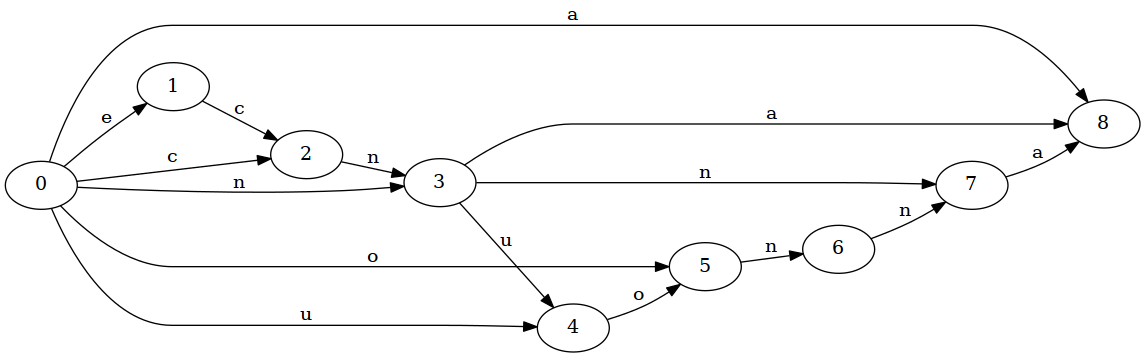

In [13]:
def build_oracle(pattern):
    """The Oracle stores all suffixes for the reverse of a given pattern.
    
    It is used to detect factors/infixes of the pattern: If we can reach
    a state in the oracle from the initial state with a given string, this
    string is a factor/infix of the pattern.
    
    It has the pecularity of storing more than these, though, which is
    a side-effect of its algorithm. This is of no detriment for searching,
    though.
    """
    pattern = pattern[::-1]
    m = 0
    S = {}
    start = State(m)
    S[m] = None
    cur_state = start
    for idx, char in enumerate(pattern):
        m += 1
        new_state = State(m)
        cur_state.add_transition(char, new_state)
        k = S[m-1]
        while k is not None and char not in k.transitions:
            k.add_transition(char, new_state)
            k = S[k.id]
        if k is None:
            S[m] = start
        else:
            S[m] = k.transitions[char]
        cur_state = new_state
    return start
        
oracle = build_oracle('announce')
print_automaton(oracle)

In [14]:
def bom_search(text, pattern):
    oracle = build_oracle(pattern)
    pos = -1
    n = len(text) - 1
    m = len(pattern)
    while pos <= n - m:
        current = oracle
        j = m
        while j > 0 and current is not None:
            char = text[pos+j]
            current = current.transitions.get(char, None)
            j -= 1
        if current is not None:
            yield pos + 1
        pos += j + 1
        
print_highlighted_tests(bom_search)

`foo`: Ich bin ein Moo**foo** der in B**arf**oo lebt.

`abracadabra`: And the magician said: '**abracadabracadabra**, simsalabim!'

`announce`: CPM_annual_conference_**announce**

`pattern`: I have an overlapping patpatt**pattern**!

`nde?`: Pattern ganz am E**nde?**

`Pat`: **Pat**tern ganz am Anfang?

# Multiples String Matching

![](img/multi_pattern.png)

- Anstatt nach nur einem Pattern im Text zu suchen, wollen wir mehrere
- Naiv könnte man einfach auch die obigen Algorithmen sequentiell
  anwenden, dies ist allerdings ineffizient
- **Grundlegender Ansatz**: Die Pattern einem DAWG repräsentieren, mit
  diesem die Suche optimieren

## Präfix-basierte Ansätze

![](img/multi_prefix.png)

### Multiple Shift-And

![](img/multi_shiftand.png)

In [15]:
def multi_shiftand(text, patterns):
    raise NotImplementedError

### Aho-Corasick

- Wir bilden einen DAWG/Trie aus den Pattern
- Wir ergänzen sog. *supply links* im Trie, diese geben an, wo
  das **längste gerade gelesene Suffix** des Patterns auch **Präfix eines
  anderen Patterns** ist und zeigen auf den den Zustand, den man
  mit diesem Präfix vom Startzustand erreichen würde.

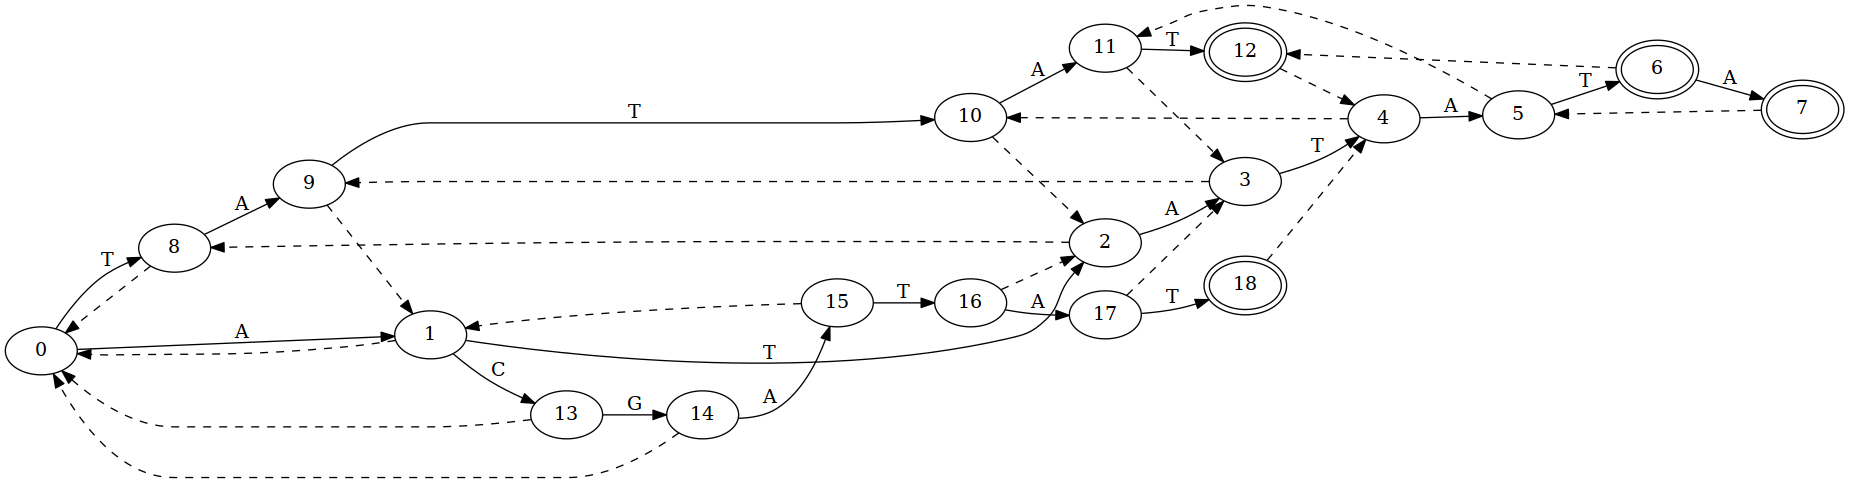

In [16]:
class AhoCorasickAutomaton:
    def __init__(self, strings):
        idx = 0
        self.start = State(idx)
        self.parents = {}  # state-id -> parent of state
        self.states = [self.start]  # list of all states
        # state-id -> patterns that end on this state
        self.finals = defaultdict(list)
        for s in strings:
            cur, rest = self.start.longest_prefix(s)
            for char in rest:
                idx += 1
                new_state = State(idx)
                cur.add_transition(char, new_state)
                self.parents[new_state.id] = cur
                self.states.append(new_state)
                cur = new_state
            cur.final = True
            self.finals[cur.id].append(s)
        self.supply_links = self._build_supply_links()
    
    def as_dot(self, with_supply_links=True):
        # We have to override this method, since we have to render
        # the supply links as well.
        out = self.start.as_dot()
        for id, state in self.supply_links.items():
            if not with_supply_links or state is None:
                continue
            out.append("{} -> {} [style=\"dashed\"]"
                       .format(id, state.id))
        return out
    
    def _root_distance(self, state):
        """ Return the distance of a given state to the initial state.
        """
        dist = 0
        parent = state
        while parent != self.start:
            parent = self.parents[parent.id]
            dist += 1
        return dist
    
    def _transversal_iter(self):
        """ Iterate through all states in transversal order.
        
        Transversal order means that states are ordered by their distance
        to the initial state. The order of states with the same distance
        is of no importance and may differ.
        """
        return sorted(self.states, key=self._root_distance)
            
    def _build_supply_links(self):
        links = {self.start.id: None}
        for current in self._transversal_iter():
            if current == self.start:
                continue
            parent = self.parents[current.id]
            sigma = next(
                char for char, child in parent.transitions.items()
                if child == current)
            down = links[parent.id]
            while down is not None and sigma not in down.transitions:
                down = links[down.id]
            if down is not None:
                links[current.id] = down.transitions[sigma]
                if links[current.id].final:
                    current.final = True
                    self.finals[current.id].append(
                        self.finals[links[current.id].id])
            else:
                links[current.id] = self.start
        return links

acaut = AhoCorasickAutomaton(['ATATATA', 'TATAT', 'ACGATAT'])
print_automaton(acaut)

[0, 7]


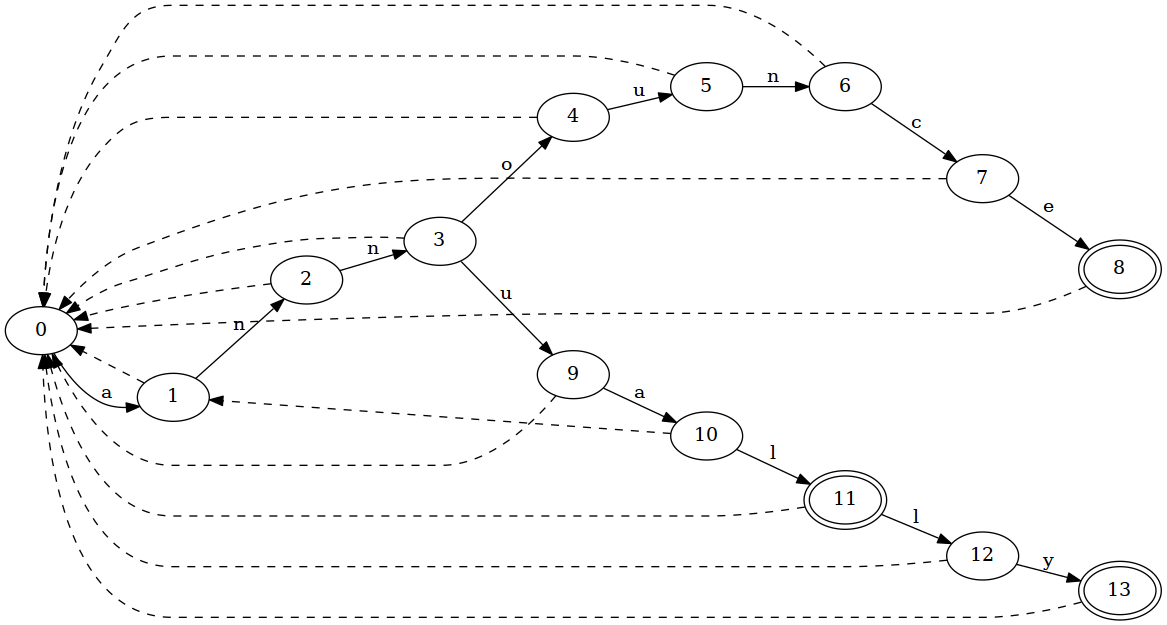

In [17]:
def ac_search(text, patterns):
    trie = AhoCorasickAutomaton(patterns)
    current = trie.start
    for pos, char in enumerate(text):
        while (char not in current.transitions and
               trie.supply_links[current.id] is not None):
            current = trie.supply_links[current.id]
        if char in current.transitions:
            current = current.transitions[char]
        else:
            current = trie.start
        if current.final:
            for pat in trie.finals[current.id]:
                yield pos - len(pat) + 1

text = "annual_announce"
patterns = ["announce", "annual", "annually"]
print(list(ac_search(text, patterns)))
print_automaton(AhoCorasickAutomaton(patterns))

## Suffix-basierte Ansätze

![](img/multi_suffix.png)

### Wu-Manber

- Anstatt Zeichen-weise durch das Fenster zu gehen wird der Text blockweise eingelesen.
- Für jedes Pattern wird überprüft, ob sie auf den Textblock enden:
  - Wenn **ja**: Überprüfe ob dieses Pattern an dieser Stelle tatsächlich endet
  - Wenn **für keines**: Verschiebe Pattern so weit, dass der gerade gelesene Block
    mit dem "rechtesten" Vorkommen dieses Blocks in allen Pattern aligniert ist,
    sollte der Block in keinem Pattern vorkommen ergibt sich eine Verschiebung
    von `lmin - B + 1`, wobei `lmin` die Länge des kürzesten Patterns ist und `B`
    die Größe des Blocks

In [18]:
def wu_manber_search(text, patterns):
    alphabet_size = len(set(itertools.chain(*patterns)))
    l_min = min(len(p) for p in patterns)
    block_size = math.log(2*l_min*len(patterns), alphabet_size)
    min_shift = l_min - block_size + 1
    
    # Create a block -> hash mapping and a hash -> patterns mapping
    # Not implemented here
    hash_table, reverse_hash_table = build_hash_tables(patterns)
    # Create a hash -> shift mapping
    shift_table = build_shift_table(hash_table, patterns)  # Not implemented here
    
    pos = l_min
    while pos < len(text):
        block = text[pos-block_size:pos]
        i = hash_table.get(i)
        shift = shift_table.get(i, min_shift)
        if shift == 0:
            for pat in reverse_hash_table[i]:
                if text[pos-len(pat):pos] == pat:
                    yield pos
            pos += 1
        else:
            pos += shift

## Faktor-basierte Ansätze

![](img/multi_factor.png)

### Multiple BNDM

![](img/multi_bndm.png)

- Die Bit-Tabelle enthält Vektoren der Länge `l_min x num_patterns`, wobei `l_min` die Länge des kürzesten Patterns ist
- Es werden nur die Suffixe der

In [19]:
# FIXME: SNAFU, the pseudo code in the book is broken

import itertools

def make_char_table(patterns):
    alphabet = set(itertools.chain(*patterns))
    l_min = min(len(p) for p in patterns)
    table = {char: BitArray('0b' + ''.join(
                '1' if c == char else '0'
                for c in itertools.chain(
                    *(reversed(p[:l_min]) for p in patterns))))
             for char in alphabet}
    return table

def multi_bndm_search(text, patterns):
    l_min = min(len(p) for p in patterns)
    
    bit_table = make_char_table(patterns)
    
    # FIXME: These might be wrong
    shift_vec = BitArray('0b' + ('1' + '0'*(l_min-1))*len(patterns))
    found_vec = BitArray('0b' + ('1'*(l_min-1) + '0')*len(patterns))
    
    pos = 0
    while pos < len(text) - l_min:
        j = last = l_min
        D = BitArray('0b' + '0' * l_min * len(patterns))
        zero_vec = BitArray('0b' + '1' * l_min * len(patterns))
        while D != zero_vec:
            D &= bit_table.get(text[pos+j], zero_vec)
            j -= 1
            if (D & found_vec) != zero_vec:
                if j > 0:
                    last = j
                else:
                    check_list = D[::l_min]
                    for pat_pos, checked in enumerate(check_list):
                        if checked:
                            pat = patterns[pat_pos]
                            if text[pos: pos+len(pat)] == pat:
                                yield pos
            D = (D << 1) & shift_vec
        pos += last
        
        
list(multi_bndm_search("Bier Wein Schnaps Limo", ["Bier", "Schnaps"]))
    

IndexError: string index out of range

### Set Backward Oracle Matching

- **Grundidee:** Suffix-Automat auf allen Pattern der mindestens alle Faktoren/Infixe der Pattern erkennt (vgl. Backward Oracle Matching)
- **Unterschied zu Backward Oracle:** Der Automat wird ähnlich wie bei Aho-Corasick mit *supply-links* erweitert. (TODO: Unterschied zu Aho-Corasick)

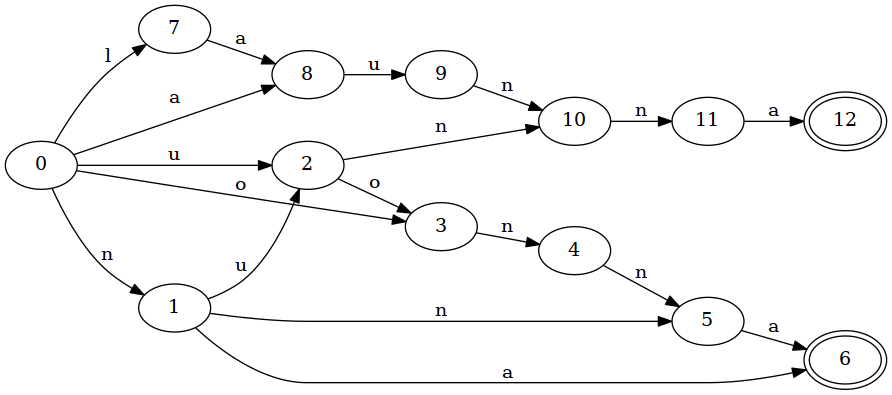

In [21]:
class SetBackwardOracle(AhoCorasickAutomaton):
    def __init__(self, patterns):
        # We need to build an automaton for the reverse patterns
        all_suffixes = ["".join(reversed(p)) for p in patterns]
        super().__init__(list(all_suffixes))

    def _build_supply_links(self):
        links = {self.start.id: None}
        for current in self._transversal_iter():
            if current == self.start:
                continue
            parent = self.parents[current.id]
            sigma = next(
                char for char, child in parent.transitions.items()
                if child == current)
            down = links[parent.id]
            while down is not None and sigma not in down.transitions:
                # NOTE: Here is one difference to the AC automaton:
                # We also add a real transition to the automaton 
                # This has the effect of transforming the DAWG from
                # a simple Trie to one that recognizes *all* suffixes
                down.add_transition(sigma, current)
                down = links[down.id]
            if down is not None:
                links[current.id] = down.transitions[sigma]
                # NOTE: Another difference: We *do not* add additional
                # final states depending on the supply links
            else:
                links[current.id] = self.start
        return links
    
    def as_dot(self):
        return super().as_dot(False)
    
sbom = SetBackwardOracle(['announ', 'annual'])
print_automaton(sbom)

In [50]:
def sbom_search(text, patterns):
    l_min = min(len(p) for p in patterns)
    oracle = SetBackwardOracle([p[:l_min] for p in patterns])
    
    pos = -1
    while pos <= len(text) - l_min:
        current = oracle.start
        j = l_min-1
        while j >= 1 and current is not None:
            char = text[pos+j]
            current = current.transitions.get(char,  None)
            j -= 1
            print("c2har={}, j={}, cur={}".format(char, j, current))
        if current is not None and j == 0:
            print("matched suffix")
            for pat in patterns:
                if text[pos+1:pos+len(pat)] == pat:
                    print("Match for {} at {}".format(pat, pos+1))
                    yield pos + 1
            j = 1
        pos += j
        import time
        time.sleep(1)
        print("pos", pos)
        
text = "annual_announce"
patterns = ["announce", "annual", "annually"]
print(list(sbom_search(text, patterns)))

c2har=a, j=4, cur=<State '8' with ['u'] transitions>
c2har=u, j=3, cur=<State '9' with ['n'] transitions>
c2har=n, j=2, cur=<State '10' with ['n'] transitions>
c2har=n, j=1, cur=<State '11' with ['a'] transitions>
c2har=a, j=0, cur=<State '12' with [] transitions final>
matched suffix
pos 0
c2har=l, j=4, cur=<State '7' with ['a'] transitions>
c2har=a, j=3, cur=<State '8' with ['u'] transitions>
c2har=u, j=2, cur=<State '9' with ['n'] transitions>
c2har=n, j=1, cur=<State '10' with ['n'] transitions>
c2har=n, j=0, cur=<State '11' with ['a'] transitions>
matched suffix
pos 1
c2har=_, j=4, cur=None
pos 5
c2har=o, j=4, cur=<State '3' with ['n'] transitions>
c2har=n, j=3, cur=<State '4' with ['n'] transitions>
c2har=n, j=2, cur=<State '5' with ['a'] transitions>
c2har=a, j=1, cur=<State '6' with [] transitions final>
c2har=_, j=0, cur=None
pos 5
c2har=o, j=4, cur=<State '3' with ['n'] transitions>
c2har=n, j=3, cur=<State '4' with ['n'] transitions>
c2har=n, j=2, cur=<State '5' with ['a'] t

KeyboardInterrupt: 

In [ ]:
# Reguläre Ausdrücke

![](img/regex_overview.png)

## Parsen in einen Syntaxbaum

## Automatenaufbau

### Nach Thompson

### Nach Glushkov

## Suche

### Bit-Parallele Suche

### Filter-Ansätze

# Approximative Suche

## Levenshtein mit Wagner-Fisher
![](img/wagnerfisher.png)

## Levenshtein mit Ukkonnen
![](img/ukkonen.png)

## Bit-Paralleler Wagner-Fisher

### Ansatz
Eigenschaften der Matrix:
- Diagonaleigenschaft: `M[i,j] - M[i-1, j-1] = 0 oder 1`
- Nachfolgeeigenschaften:
  - `M[i,j] - M[i, j-1] in {-1, 0, 1}`
  - `M[i,j] - M[i-1, j] in {-1, 0, 1}`
  
Kodiere die Differenzen aufeinanderfolgender Zelleinträge durch
boolesche Vektoren:
- Vertical positive: `VP[i,j] = 1 iff M[i,j] - M[i-1, j] = 1`
- Vertical negative: `VN[i,j] = 1 iff M[i,j] - M[i-1, j] = -1`
- Horizontal positive: `HP[i,j] = 1 iff M[i,j] - M[i, j-1] = 1`
- Horizontal negative: `HN[i,j] = 1 iff M[i,j] = M[i, j-1] = -1`
- Diagonal-Zero: `D0[i,j] = 1 iff M[i,j] = M[i-1, j-1]`

**Beachte:** Da die 0te Zeile und die 0te Spalte feste Initialwerte haben
(Spalte: `[0, 1, ... m]`, Zeile: `[0, 0, ...]`) können aus den obigen
Vektoren alle Matrixwerte `M[i,j]` rekonstruiert werden. Wir werden
später jedoch nur die Werte `M[m,j]` rekonstruieren.

**Idee:** Möchten spaltenweise die booleschen Vektoren updaten.
Hierzu werden Abhängigkeiten ausgenützt:
- `HN[i,j] <=> VP[i,j-1] AND D0[i,j]`
- `VN[i,j] <=> HP[i-1,j] AND D0[i,j]`
- `HP[i,j] <=> VN[i,j-1] OR NOT(VP[i,j-1] OR DO[i,j])`
- `VP[i,j] <=> HN[i-1,j] OR NOT(HP[i-1,j] OR D0[i,j])`
- `D0[i,j] <=> (P[i] = T[j]) OR VN[i,j-1] OR HN[i-1,j]`

**Berechungsreihenfolge:**
1. `D0`
2. `HN` und `HP`
3. `VN` und `VP`

**Problem:** Für `D0` ergibt sich eine zirkuläre Abhängigkeit:  
```
D0[i,j] <=> (Pi] = T[j]) OR VN[i,j-1] OR (VP[i-1,j-1] AND D0[i-1,j])
   ^        -------------------------    ------------         ^
  !!!                    X[i]                Y[i-1]          !!!
```

Verkürzte Form: `D0[i] <=> X[i] OR (Y[i-1] AND D[i-1,j]`

*Siehe Buch:* Durch Umformungen dieser Gleichung:  
`D0 = ((Y + (X AND Y)) X OR Y) OR X`

### Algorithmus
- Initialisierung:
  - `VP[i,0] = 1, VN[i,0] = 0` für i=1..m
  - `M[m,0] = m`
- Danach wird iterativ Spalte `j` aus `j-1` berechnet:
  1. Zuerst `D0[-,j]` durch `(P[i] = T[j])` und `VN[-,j-1]`
  2. `HP[-,j]`, `HN[-,j]` durch `D0[-,j]`, `VP[-,j-1]`, `VN[-,j-1]`
  3. Wert `M[m,j]` über `M[m,j-1]` und `HP[m,j]`, `HN[m,j]`
  4. Vertikale Vektoren: `VP[-,j]`, `VN[-,j]`

## Bit-Paralleler Ukkonen
```
Start mit `R_i = 0^(m-i) 1^i`
Update zuerst Zeile 0: Shift von 1, Bitmaske des Textsymbols schneiden
                       OR 0..01
R'_0 <- (R_0 << 1) | (O^(m-1) & B[t_j]
R'_i <- (R_i << 1) & B[t_j] | R_i-1 | (R_i-1 << 1) | (R'_i-1 << 1)
```